In [1]:
# ------- Notebook config
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

# ------- Load dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import gdal, os, osr
from scipy import stats
import random, ast, csv, math

In [13]:
dataDir = 'Y:/DanK/SFFireshed_Swap/SFF_CCSM_NoMan/replicate16/output/PNEToutputsites/'

In [132]:
siteNames = next(os.walk(dataDir))[1]

sitefile = dataDir + siteNames[7] + '/Site.csv'
siteDF   = pd.read_csv(sitefile)

In [133]:
year_start = int(np.floor(siteDF.Time.min()))
year_end   = int(np.ceil(siteDF.Time.max()))

In [134]:
tempTS = pd.date_range(str(year_start), str(year_end), freq='MS')
TS     = tempTS[:-1]

In [135]:
siteDF['TS'] = TS
siteDF.index    = siteDF.TS
siteDF['Month'] = siteDF.index.month
siteDF['Year']  = siteDF.index.year

In [136]:
climate      = ['PAR0', 'Tday(C)', 'Precip(mm/mo)','VPD(kPa)']
precipFate   = ['Precip(mm/mo)', 'RunOff(mm/mo)', 
                     'Leakage(mm)','Transpiration(mm)','Interception(mm)']
soilMoisture   = ['water(mm)','PressureHead(mm)','SnowPack(mm)']
carbonExchange = ['GrossPsn(gC_m2_mo)',
                  'NetPsn(gC_m2_mo)', 'MaintenanceRespiration(gC_mo)']
biomass        = ['Wood(gDW)','Root(gDW)', 'Fol(gDW)']

siteDF['Biomass(g)'] = siteDF[biomass].sum(axis=1)

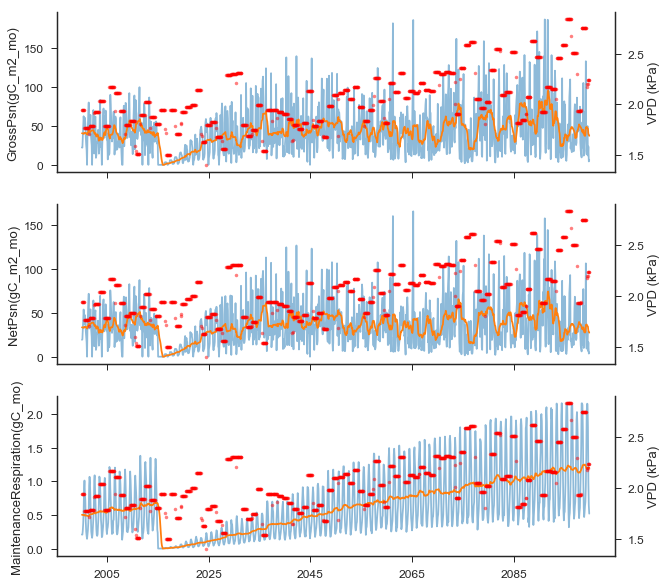

In [156]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (10,10), sharex = True)
axs = f.axes
idx = 0

datestart = '2000-01-01'
dateend   = '2099-12-01'
for sitevar in carbonExchange:
    ax = axs[idx]
    ax.plot(siteDF[sitevar].loc[datestart:dateend], alpha = 0.5)
    ax.plot(siteDF[sitevar].rolling(12).mean().loc[datestart:dateend])
    ax2 = ax.twinx()
    ax.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.plot(siteDF['VPD(kPa)'].rolling(12).max().loc[datestart:dateend], 
             ls = '', marker = '.', color = 'red', alpha = 0.5)
    ax2.set_ylabel('VPD (kPa)')

    
    ax.set_ylabel(sitevar)
    idx += 1
    
#sns.despine()
sns.set_style('ticks')
sns.set_context('notebook', font_scale=1.2)

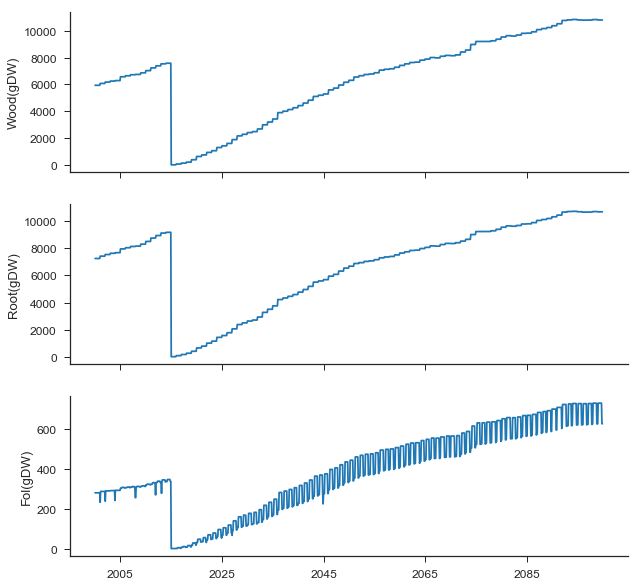

In [138]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (10,10), sharex = True)
axs = f.axes
idx = 0

datestart = '2000-01-01'
dateend   = '2099-12-01'
for sitevar in biomass:
    ax = axs[idx]
    ax.plot(siteDF[sitevar].loc[datestart:dateend])
    
    ax.set_ylabel(sitevar)
    idx += 1
    
sns.despine()
sns.set_style('ticks')
sns.set_context('notebook', font_scale=1.2)

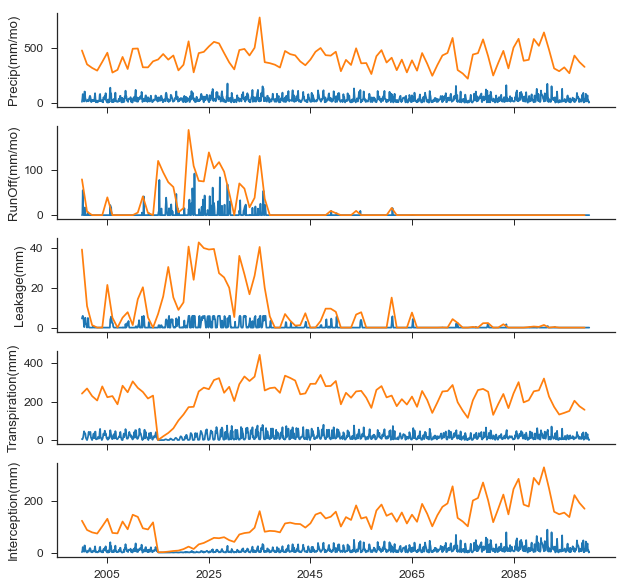

In [139]:

siteDF_A = siteDF.groupby(['Year']).sum().reset_index()
yearTS   = pd.date_range(str(siteDF_A.Year.min()), str(siteDF_A.Year.max()), freq='YS')
siteDF_A.index = yearTS

f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize = (10,10), sharex = True)
axs = f.axes
idx = 0

datestart = '2000-01-01'
dateend   = '2099-12-01'
for sitevar in precipFate:
    ax = axs[idx]
    ax.plot(siteDF[sitevar].loc[datestart:dateend])
    ax.plot(siteDF_A[sitevar].loc['2000':'2099'])

    
    ax.set_ylabel(sitevar)
    idx += 1
    
sns.despine()
sns.set_style('ticks')
sns.set_context('notebook', font_scale=1.2)

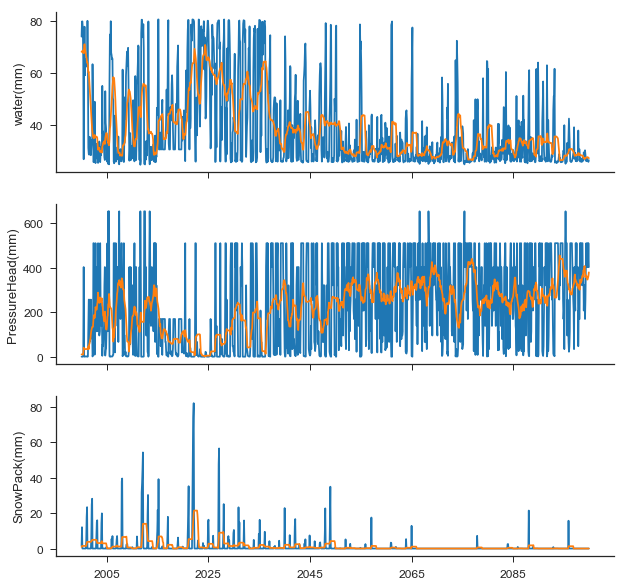

In [140]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (10,10), sharex = True)
axs = f.axes
idx = 0

datestart = '2000-01-01'
dateend   = '2099-12-01'
for sitevar in soilMoisture:
    ax = axs[idx]
    ax.plot(siteDF[sitevar].loc[datestart:dateend])
    ax.plot(siteDF[sitevar].rolling(12).mean().loc[datestart:dateend])
    
    ax.set_ylabel(sitevar)
    idx += 1
    
sns.despine()
sns.set_style('ticks')
sns.set_context('notebook', font_scale=1.2)